In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split

In [ ]:
import torch

print("CUDA available:", torch.cuda.is_available())
print("Device count:", torch.cuda.device_count())
print("GPU name:", torch.cuda.get_device_name(0))


CUDA available: True
Device count: 1
GPU name: Tesla T4


# ResNet18 Architecture

### Residual Block class

In [ ]:
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_channels, out_channels, stride=1):
        super().__init__()

        self.conv1 = nn.Conv2d(
            in_channels, out_channels,
            kernel_size=3, stride=stride, padding=1, bias=False
        )
        self.bn1 = nn.BatchNorm2d(out_channels)

        self.conv2 = nn.Conv2d(
            out_channels, out_channels,
            kernel_size=3, stride=1, padding=1, bias=False
        )
        self.bn2 = nn.BatchNorm2d(out_channels)

        # Shortcut
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(
                    in_channels, out_channels,
                    kernel_size=1, stride=stride, bias=False
                ),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


# **Residual Connections**

### ResNet18 Model Definition

In [ ]:
class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super().__init__()
        self.in_channels = 64

        self.conv1 = nn.Conv2d(
            1, 64, kernel_size=3, stride=1, padding=1, bias=False
        )
        self.bn1 = nn.BatchNorm2d(64)

        self.layer1 = self._make_layer(block, 64,  num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)

        self.fc = nn.Linear(512, num_classes)

    def _make_layer(self, block, out_channels, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []

        for s in strides:
            layers.append(block(self.in_channels, out_channels, s))
            self.in_channels = out_channels

        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, out.shape[2])
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out


### ResNet18 Constructor

In [ ]:
def ResNet18():
    return ResNet(BasicBlock, [2, 2, 2, 2])


In [ ]:
class ThreeBlockConvLayers(nn.Module):
    def __init__(self, in_channels, block1_channels, block2_channels, block3_channels):
        super().__init__()

        self.block1 = BasicBlock(in_channels, block1_channels, stride=1)
        self.block2 = BasicBlock(block1_channels, block2_channels, stride=2)
        self.block3 = BasicBlock(block2_channels, block3_channels, stride=2)

    def forward(self, x):
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        return x


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

class ThreeBlockResNetClassifier(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()

        # Initial conv to go from 1 channel → 64
        self.stem = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True)
        )

        # Your three residual blocks
        self.features = ThreeBlockConvLayers(
            in_channels=64,
            block1_channels=128,
            block2_channels=256,
            block3_channels=512
        )

        # Classification head
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, num_classes)

    def forward(self, x):
        x = self.stem(x)
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x


### Dataset & Dataloader

In [ ]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

full_train_dataset = datasets.FashionMNIST(
    root="./data",
    train=True,
    download=True,
    transform=transform
)

train_size = 50000
val_size = 10000

train_dataset, val_dataset = random_split(
    full_train_dataset, [train_size, val_size]
)

test_dataset = datasets.FashionMNIST(
    root="./data",
    train=False,
    download=True,
    transform=transform
)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
val_loader   = DataLoader(val_dataset,   batch_size=128, shuffle=False)
test_loader  = DataLoader(test_dataset,  batch_size=128, shuffle=False)


### Model, Loss, Optimizer

In [ ]:
torch.manual_seed(32)


In [ ]:
import torch.nn as nn
import torch.optim as optim

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ResNet18().to(device)

criterion = nn.CrossEntropyLoss()
optimizer2 = torch.optim.SGD(
    model.parameters(),
    lr=0.1,
    momentum=0.9,
    weight_decay=5e-4
)


### train

In [ ]:
import matplotlib.pyplot as plt

num_epochs = 15

train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

for epoch in range(num_epochs):

    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer2.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer2.step()

        running_loss += loss.item()
        _, preds = outputs.max(1)
        total += labels.size(0)
        correct += preds.eq(labels).sum().item()

    train_loss = running_loss / len(train_loader)
    train_acc = 100 * correct / total

    train_losses.append(train_loss)
    train_accuracies.append(train_acc)


    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            _, preds = outputs.max(1)
            total += labels.size(0)
            correct += preds.eq(labels).sum().item()

    val_loss = running_loss / len(val_loader)
    val_acc = 100 * correct / total


    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    print(
        f"Epoch [{epoch+1}/{num_epochs}] | "
        f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}% | "
        f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%"
    )

print(" Training + Validation completed")

Epoch [1/15] | Train Loss: 1.0216, Train Acc: 67.31% | Val Loss: 0.5416, Val Acc: 79.56%
Epoch [2/15] | Train Loss: 0.4228, Train Acc: 84.44% | Val Loss: 0.3690, Val Acc: 86.32%
Epoch [3/15] | Train Loss: 0.3473, Train Acc: 87.38% | Val Loss: 0.4156, Val Acc: 85.55%
Epoch [4/15] | Train Loss: 0.2925, Train Acc: 89.46% | Val Loss: 0.3297, Val Acc: 87.91%
Epoch [5/15] | Train Loss: 0.2644, Train Acc: 90.21% | Val Loss: 0.4471, Val Acc: 84.69%
Epoch [6/15] | Train Loss: 0.2428, Train Acc: 91.11% | Val Loss: 0.2854, Val Acc: 90.04%
Epoch [7/15] | Train Loss: 0.2288, Train Acc: 91.65% | Val Loss: 0.3194, Val Acc: 88.71%
Epoch [8/15] | Train Loss: 0.2172, Train Acc: 92.09% | Val Loss: 0.2748, Val Acc: 90.26%
Epoch [9/15] | Train Loss: 0.2073, Train Acc: 92.51% | Val Loss: 0.2542, Val Acc: 90.95%
Epoch [10/15] | Train Loss: 0.1975, Train Acc: 92.80% | Val Loss: 0.2384, Val Acc: 91.51%
Epoch [11/15] | Train Loss: 0.1919, Train Acc: 93.00% | Val Loss: 0.2234, Val Acc: 92.08%
Epoch [12/15] | Tra

In [ ]:
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f" Test Accuracy: {accuracy:.2f}%")


 Test Accuracy: 88.17%


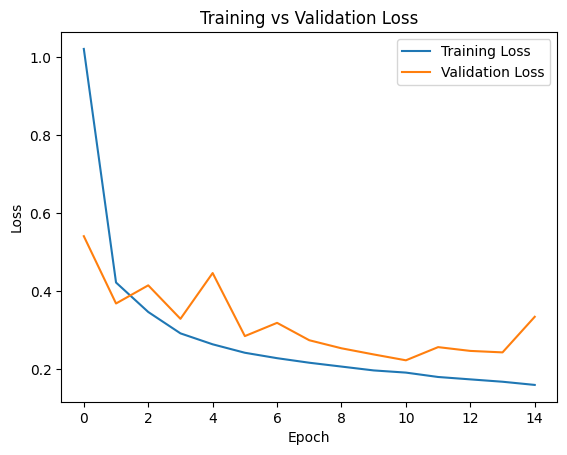

In [ ]:
plt.figure()
plt.plot(train_losses, label="Training Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Training vs Validation Loss")
plt.show()


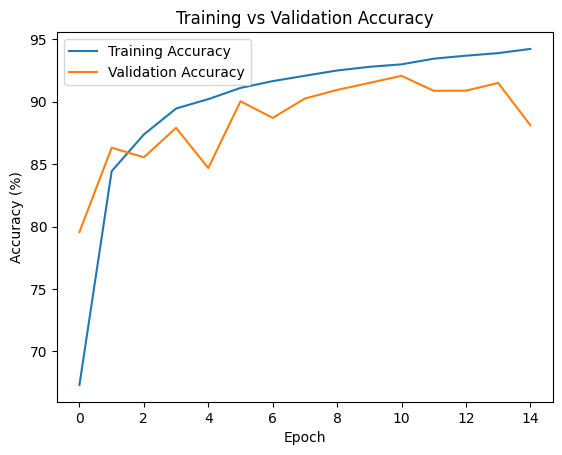

In [ ]:
plt.figure()
plt.plot(train_accuracies, label="Training Accuracy")
plt.plot(val_accuracies, label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.legend()
plt.title("Training vs Validation Accuracy")
plt.show()


FAILURE CASES

Total failure cases: 1183


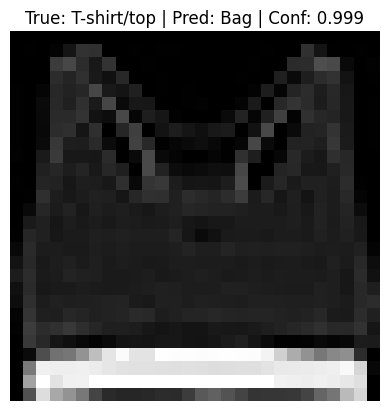

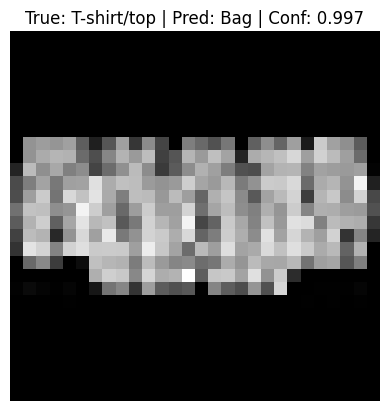

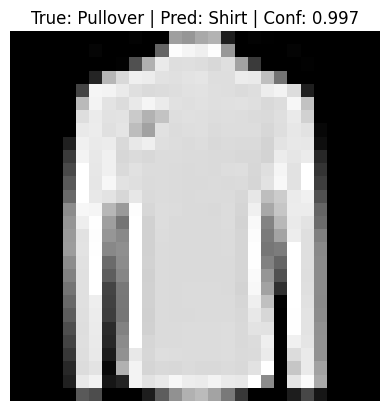

In [ ]:
import torch.nn.functional as F
import matplotlib.pyplot as plt

model.eval()

failure_cases = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        probs = F.softmax(outputs, dim=1)
        confidence, predicted = torch.max(probs, 1)

        for i in range(images.size(0)):
            if predicted[i] != labels[i]:
                failure_cases.append({
                    "image": images[i].cpu(),
                    "true": labels[i].cpu().item(),
                    "pred": predicted[i].cpu().item(),
                    "conf": confidence[i].cpu().item()
                })

print("Total failure cases:", len(failure_cases))

failure_cases = sorted(failure_cases, key=lambda x: x["conf"], reverse=True)

class_names = [
    "T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
    "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"
]

def show_failure(case):
    img = case["image"]
    img = img * 0.5 + 0.5

    plt.imshow(img.squeeze(), cmap="gray")
    plt.title(
        f"True: {class_names[case['true']]} | "
        f"Pred: {class_names[case['pred']]} | "
        f"Conf: {case['conf']:.3f}"
    )
    plt.axis("off")
    plt.show()

for i in range(3):
    show_failure(failure_cases[i])



**Grad-CAM**

In [ ]:
activations = None
gradients = None

def forward_hook(module, input, output):
    global activations
    activations = output

def backward_hook(module, grad_in, grad_out):
    global gradients
    gradients = grad_out[0]

target_layer = model.layer4[-1]

target_layer.register_forward_hook(forward_hook)
target_layer.register_backward_hook(backward_hook)

import cv2
import numpy as np

def generate_gradcam(image_tensor, class_idx):

    model.zero_grad()

    output = model(image_tensor)
    score = output[:, class_idx]
    score.backward()

    global activations, gradients

    pooled_gradients = torch.mean(gradients, dim=[0, 2, 3])

    for i in range(activations.shape[1]):
        activations[:, i, :, :] *= pooled_gradients[i]

    heatmap = torch.mean(activations, dim=1).squeeze()
    heatmap = torch.relu(heatmap)
    heatmap /= torch.max(heatmap)

    heatmap = heatmap.cpu().detach().numpy()
    heatmap = cv2.resize(heatmap, (28, 28))

    return heatmap


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/module.py:1866: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


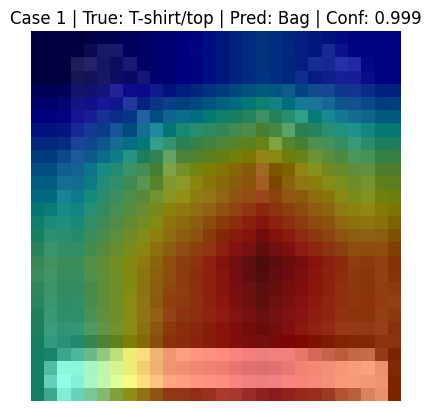

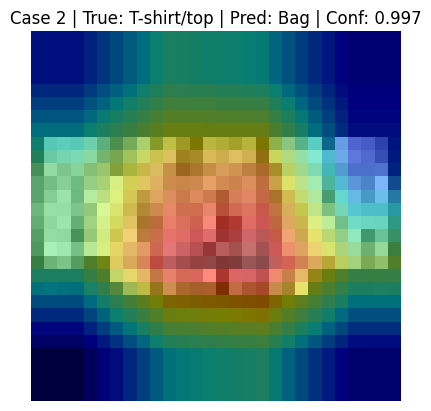

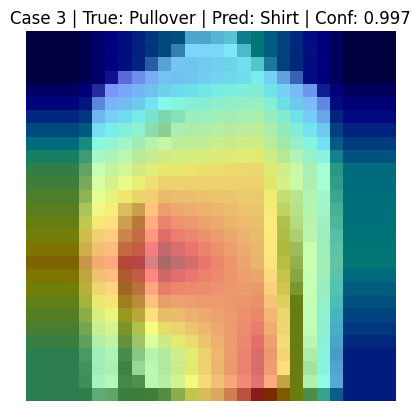

In [ ]:
for i in range(3):

    case = failure_cases[i]

    image = case["image"].unsqueeze(0).to(device)
    pred_class = case["pred"]

    image.requires_grad = True

    heatmap = generate_gradcam(image, pred_class)

    img = case["image"].cpu().numpy()
    img = img * 0.5 + 0.5
    img = img.squeeze()

    plt.figure()
    plt.imshow(img, cmap="gray")
    plt.imshow(heatmap, cmap="jet", alpha=0.5)

    plt.title(
        f"Case {i+1} | "
        f"True: {class_names[case['true']]} | "
        f"Pred: {class_names[case['pred']]} | "
        f"Conf: {case['conf']:.3f}"
    )

    plt.axis("off")
    plt.show()



# Improved Model

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ResNet18().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(
    model.parameters(),
    lr=0.001,

)

In [ ]:
scheduler = torch.optim.lr_scheduler.StepLR(
    optimizer, step_size=5, gamma=0.1
)

In [ ]:
num_epochs = 15

train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

for epoch in range(num_epochs):

    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, preds = outputs.max(1)
        total += labels.size(0)
        correct += preds.eq(labels).sum().item()

    train_loss = running_loss / len(train_loader)
    train_acc = 100 * correct / total

    train_losses.append(train_loss)
    train_accuracies.append(train_acc)


    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            _, preds = outputs.max(1)
            total += labels.size(0)
            correct += preds.eq(labels).sum().item()

    val_loss = running_loss / len(val_loader)
    val_acc = 100 * correct / total


    val_losses.append(val_loss)
    val_accuracies.append(val_acc)
    scheduler.step()
    print(
        f"Epoch [{epoch+1}/{num_epochs}] | "
        f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}% | "
        f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%"
    )

print(" Training + Validation completed")


Epoch [1/15] | Train Loss: 0.4362, Train Acc: 84.26% | Val Loss: 0.3292, Val Acc: 88.14%
Epoch [2/15] | Train Loss: 0.2529, Train Acc: 90.71% | Val Loss: 0.2491, Val Acc: 90.97%
Epoch [3/15] | Train Loss: 0.2064, Train Acc: 92.40% | Val Loss: 0.2418, Val Acc: 90.97%
Epoch [4/15] | Train Loss: 0.1797, Train Acc: 93.36% | Val Loss: 0.2323, Val Acc: 91.88%
Epoch [5/15] | Train Loss: 0.1546, Train Acc: 94.39% | Val Loss: 0.2237, Val Acc: 92.38%
Epoch [6/15] | Train Loss: 0.0856, Train Acc: 97.12% | Val Loss: 0.1774, Val Acc: 93.81%
Epoch [7/15] | Train Loss: 0.0612, Train Acc: 98.00% | Val Loss: 0.1930, Val Acc: 93.66%
Epoch [8/15] | Train Loss: 0.0447, Train Acc: 98.65% | Val Loss: 0.2040, Val Acc: 93.79%
Epoch [9/15] | Train Loss: 0.0308, Train Acc: 99.11% | Val Loss: 0.2300, Val Acc: 93.90%
Epoch [10/15] | Train Loss: 0.0190, Train Acc: 99.49% | Val Loss: 0.2611, Val Acc: 93.82%
Epoch [11/15] | Train Loss: 0.0088, Train Acc: 99.86% | Val Loss: 0.2554, Val Acc: 93.90%
Epoch [12/15] | Tra

In [ ]:
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f" Test Accuracy: {accuracy:.2f}%")


 Test Accuracy: 93.70%


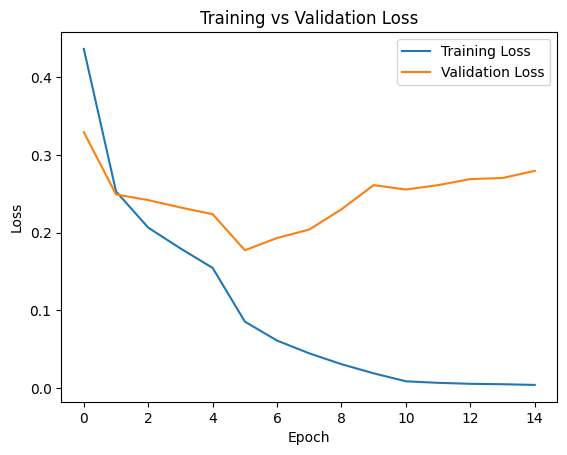

In [ ]:

import matplotlib.pyplot as plt
plt.figure()
plt.plot(train_losses, label="Training Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Training vs Validation Loss")
plt.show()


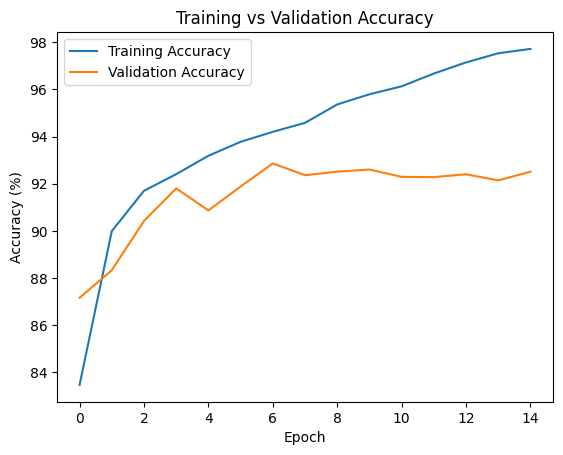

In [ ]:
plt.figure()
plt.plot(train_accuracies, label="Training Accuracy")
plt.plot(val_accuracies, label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.legend()
plt.title("Training vs Validation Accuracy")
plt.show()
